<a href="https://colab.research.google.com/github/Norberto27/-IAAA2-DISTANCIA-A/blob/main/260625_NRMU_TP_RL2_CartPole_v1_COMPLETO_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Trabajo Práctico RL2: CartPole-v1**


**Alumno: NORBERTO RAUL MARTEARENA URQUIZA**


**notebook actualizado con los graficos solicitados por la docente**
**Los links se encuentran en el foro del TP RL2 en la plataforma del ISSD

#**1 IMPORTACION DE LIBRERIAS**

In [27]:

import gymnasium as gym         # Entorno CartPole para Aprendizaje por Refuerzo
import numpy as np              # Operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt # Gráficos y visualización de resultados
import torch                    # Soporte para tensores y cómputo con GPU
import torch.nn as nn           # Construcción de redes neuronales
import torch.nn.functional as F # Funciones de activación y pérdida para redes
import torch.optim as optim     # Algoritmos de optimización (ej. Adam)
from collections import deque   # Estructura de datos eficiente para memoria
import random                   # Selección aleatoria (exploración y shuffle)
import seaborn as sns           # Visualizaciones estadísticas más estilizada

In [28]:
#**2 CONFIGURACION Y EXPLORACION DEL ENTORNO**


🧠 2.1 Descripcion del entorno – CartPole-v1

CartPole es un entorno clásico de Aprendizaje por Refuerzo provisto por gym. Se lo conoce también como el problema del poste invertido.

El objetivo del agente es mantener el poste en posición vertical el mayor tiempo posible, mientras se balancea sobre un carrito que se desplaza hacia la izquierda o derecha.

El entorno devuelve, en cada paso, un vector de 4 valores continuos (floats) que representan el estado del sistema:

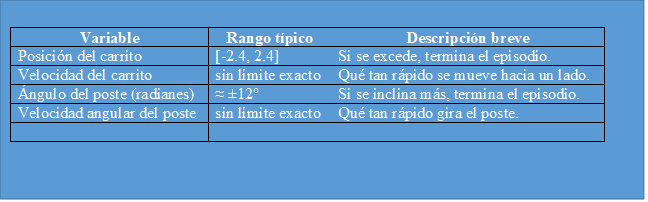
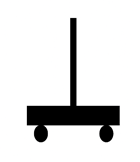

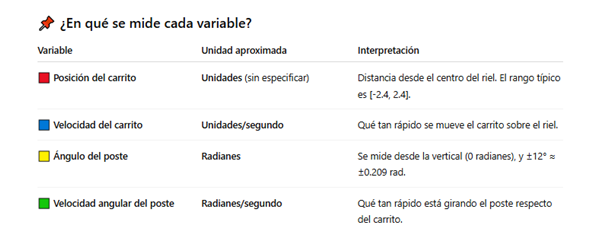







🎮 Espacio de acciones

El agente puede tomar una de dos acciones discretas:

0: empujar el carrito hacia la izquierda.

1: empujar el carrito hacia la derecha.

🏆 Recompensa

+1 por cada paso en que el poste permanece en equilibrio.

El objetivo es maximizar el número de pasos antes de que el episodio termine.

⛔ Condiciones de terminación (final del episodio)

La posición del carrito excede ±2.4 unidades.

El ángulo del poste excede ±12°.

Se alcanzan los 500 pasos (episodio exitoso).

In [29]:
# asegurar reproducibilidad
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
env = gym.make('CartPole-v1')


#**2.2 Discretizar Estados**

# En CartPole, la política es un mapeo continuo ⇒ acción (0/1) por estado.
# Para Q-Tabular discretizamos y graficamos flechas en la grilla.

In [30]:


#  🔹 Discretización del espacio de observaciones
bins = [
  np.linspace(-2.4,2.4,10),  # Posición del carrito
  np.linspace(-3.0,3.0,10),  # Velocidad del carrito
  np.linspace(-0.5,0.5,10),  # Ángulo del poste
  np.linspace(-3.5,3.5,10)   # Velocidad angular del poste
]

# Con estas líneas se definen 10 divisiones (bins) para cada una de las 4 variables del estado.
# Luego, la función discretize() convierte cualquier observación continua en una tupla de 4 índices discretos.

def discretize(obs):
  return tuple(np.digitize(obs[i],bins[i]) for i in range(4))

# “La discretización nos permite convertir un estado continuo en un
# índice discreto para poder usar tablas Q en lugar de redes neuronales.”







#**🎯 2.3 Entrenamiento de agentes – Adaptaciones necesarias en CartPole**

En esta sección comenzamos el entrenamiento del agente utilizando aprendizaje por refuerzo, y debemos tener en cuenta algunas diferencias importantes respecto al TP1 (FrozenLake). A continuación, explico las principales adaptaciones que realice para que el modelo funcione correctamente con el entorno CartPole:


**🔢 1. El espacio de estados ahora es continuo (no discreto como en FrozenLake)**

En FrozenLake teníamos 16 estados fijos.

En CartPole, el estado está formado por 4 variables continuas (posición, velocidad, ángulo y velocidad angular).

👉 Para manejar esto, aplicamos anteriormente la técnica de  discretización, usando np.digitize() en cada dimensión. Esto transforma los valores continuos en categorías discretas, para que podamos armar una tabla Q.

**🕹️ 2. Número de acciones posibles: ahora son 2, no 4**

En FrozenLake el agente podía moverse en 4 direcciones (arriba, abajo, izquierda, derecha).

En CartPole solo puede hacer dos cosas: empujar el carrito a la izquierda (0) o a la derecha (1).

👉 Por eso, adapte el código para que la función de selección de acción trabaje con dos opciones en vez de cuatro.

**⏱️ 3. Duración de los episodios**

En FrozenLake cada episodio duraba como máximo 100 pasos.

En CartPole puede durar hasta 500 pasos, si el poste se mantiene en equilibrio.

👉 Por eso también actualice los bucles de entrenamiento para contemplar este nuevo límite.

**🧠 4. Entrada de la red neuronal DQN: cambia el formato del estado**

En FrozenLake usábamos una representación “one-hot” de tamaño 16 (una lista con 15 ceros y un 1).

En CartPole usamos directamente el vector de 4 dimensiones del estado.

👉 Esto requiere ajustar cómo preparamos los datos antes de pasarlos a la red.

**📤 5. Salida de la red: ahora es de tamaño 2**

En FrozenLake la red neuronal tenía una salida para cada acción posible (4 neuronas).

En CartPole, como solo hay 2 acciones, la salida tiene 2 neuronas, una para cada acción posible.

👉 También adaptamos la arquitectura de la red para que coincida con este nuevo entorno.

- Política aleatoria utilizada como control.
- No aprende: simplemente explora sin ningún criterio.
- Resultado esperado: duración de episodio < 50 pasos.

Qué hace:

Selecciona las acciones de forma completamente aleatoria:

action = env.action_space.sample().

No hay aprendizaje, ni memoria, ni modelo.


Esta política sirve como línea base para comparar.

Se espera un rendimiento muy bajo, ya que el agente no tiene forma de aprender.

Ayuda a dimensionar cuán útiles son las otras estrategias.

#**📌 2.3.1 Política Aleatoria**

In [31]:
# 🧪 Definición de una política aleatoria
# Esta clase simula un agente que elige acciones al azar (sin aprendizaje).

class PoliticaAleatoria:
    def __init__(self, n):
        self.n = n  # n: número de acciones posibles (2 en CartPole)

    def seleccionar(self, obs):
        # Selecciona una acción aleatoria sin usar la observación (obs)
        return np.random.randint(self.n)

    def entrenar(self, env, episodios=1000):
        # Ejecuta varios episodios usando la política aleatoria
        recomp = []  # Lista para guardar las recompensas por episodio
        for _ in range(episodios):
            o, _ = env.reset()  # Reinicia el entorno y obtiene el primer estado
            done = False
            r_tot = 0  # Acumulador de recompensa por episodio
            while not done:
                a = self.seleccionar(o)  # Elige acción aleatoria
                o, r, done, _, _ = env.step(a)  # Ejecuta la acción en el entorno
                r_tot += r  # Suma la recompensa obtenida
            recomp.append(r_tot)  # Guarda recompensa total de ese episodio
        return recomp  # Devuelve todas las recompensas por episodio

# 🚀 Se crea una instancia de la política aleatoria con 2 acciones
tag = PoliticaAleatoria(env.action_space.n)

# 🎯 Entrenamos la política aleatoria durante 2000 episodios y guardamos recompensas
r_a = tag.entrenar(env, 2000)


In [62]:
# 🔹 Visualización de la política aprendida
# La segunda parte del bloque muestra gráficamente cómo actúa la política aprendida
# (es decir, qué acción tomaría el agente) en una grilla 2D de estados discretizados.
# Por simplicidad, se representan solo las dos primeras dimensiones del estado: posición y velocidad del carrito.

def plot_policy_tabular(policy, resolution=10):
  fig,ax = plt.subplots(5,5,figsize=(6,6))
  # Simplificación: Visualizar las dos primeras dimensiones
  grid = policy.reshape(resolution,resolution, -1)[:,:,0]
  for i in range(resolution):
    for j in range(resolution):
      a = grid[i,j]
      dx = -0.3 if a==0 else 0.3
      ax[i,j].arrow(0.5,0.5,dx,0,head_width=0.1)
      ax[i,j].axis('off')
  plt.suptitle('Política Q-Tabular')
  plt.show()

def plot_policy_tabular(policy):
    resolution = policy.shape[0]
    fig, ax = plt.subplots(resolution, resolution, figsize=(6, 6))

    for i in range(resolution):
        for j in range(resolution):
            a = policy[i, j]
            dx = -0.3 if a == 0 else 0.3
            ax[i, j].arrow(0.5, 0.5, dx, 0, head_width=0.1)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_xlim(0, 1)
            ax[i, j].set_ylim(0, 1)
    plt.suptitle("Política Q-Tabular (proyección 2D)")
    plt.tight_layout()
    plt.show()


# Se reorganiza la política (policy) para poder recorrer una grilla 2D.

# Por cada punto de la grilla, se dibuja una flecha hacia la izquierda (←) si la acción sugerida es 0,
# o una flecha hacia la derecha (→) si la acción sugerida es 1.

# Esto ayuda a visualizar si la política aprendida tiene coherencia, por ejemplo:

# Si el poste se cae hacia un lado, ¿el carrito se mueve para compensar?

# ¿La política reacciona diferente según la velocidad?

# ✅ Frase aclaratoria:

# Esta visualización nos permitira ver de forma intuitiva qué decisiones toma el agente en distintos estados.
# Así comprobamos si la política aprendida tiene sentido.

#**2.3.2   Q-Learning Tabular**

📌 Qué hace:

Usa una tabla Q para aprender el valor de cada acción en cada estado.

Requiere discretizar el espacio de estados (ya que CartPole tiene estados continuos y se deben convertir a estados discretos).

Se entrena durante muchos episodios y actualiza la tabla con la fórmula de Q-learning.

Esta política permite al agente aprender de la experiencia.

A pesar de la limitación de usar una tabla, logra mejorar con el tiempo.

Requiere discretización, por eso no es óptima para entornos continuos como CartPole.

Sirve como punto intermedio entre la aleatoria y la DQN.

- Se implementó una versión adaptada del Q-Learning de RL1.
- Se discretizó el espacio continuo para usar tabla Q.
- Se observó una mejora significativa respecto a la política aleatoria.

In [63]:
# 🔁 Clase del agente Q-Learning Tabular
class QLearningTabular:
    def __init__(self, env, lr=0.1, gamma=0.99, eps=1.0):
        dims = [len(b)+1 for b in bins] + [env.action_space.n]
        self.Q = np.zeros(dims)
        self.eps_history = []
        self.lr, self.gamma = lr, gamma
        self.eps, self.eps_min, self.decay = eps, 0.01, 0.995

    def seleccionar(self, obs, train=True):
        s = discretize(obs)
        if train and random.random() < self.eps:
            return random.randrange(2)
        return np.argmax(self.Q[s])

    def update(self, o, a, r, o2, done):
        s, s2 = discretize(o), discretize(o2)
        tgt = r if done else r + self.gamma * np.max(self.Q[s2])
        self.Q[s + (a,)] += self.lr * (tgt - self.Q[s + (a,)])

    def entrenar(self, env, epis=2000):
        rec = []
        for _ in range(epis):
            o, _ = env.reset()
            done = False
            r_tot = 0
            while not done:
                a = self.seleccionar(o)
                o2, r, done, _, _ = env.step(a)
                self.update(o, a, r, o2, done)
                self.eps = max(self.eps * self.decay, self.eps_min)
                self.eps_history.append(self.eps)
                o = o2
                r_tot += r
            rec.append(r_tot)
        return rec

        # 🔁 Instanciamos y entrenamos el agente
env = gym.make("CartPole-v1", render_mode=None)
qag = QLearningTabular(env)
r_q = qag.entrenar(env, 2000)
q_table = qag.Q


# Una vez entrenada la tabla Q con el algoritmo Q-Learning,
# se puede visualizar la política aprendida para las dos primeras dimensiones del entorno:
# La política muestra, para cada combinación de posición y velocidad,
# cuál es la mejor acción (izquierda o derecha) según el agente.
# Esto se hace usando la siguiente función:
# plot_policy_tabular(Q.argmax(axis=-1))
# 🔸 Nota: Esta línea debe ejecutarse solo después de haber entrenado Q.
# 🔸 Si se ejecuta antes del entrenamiento, dará error o mostrará información incorrecta.


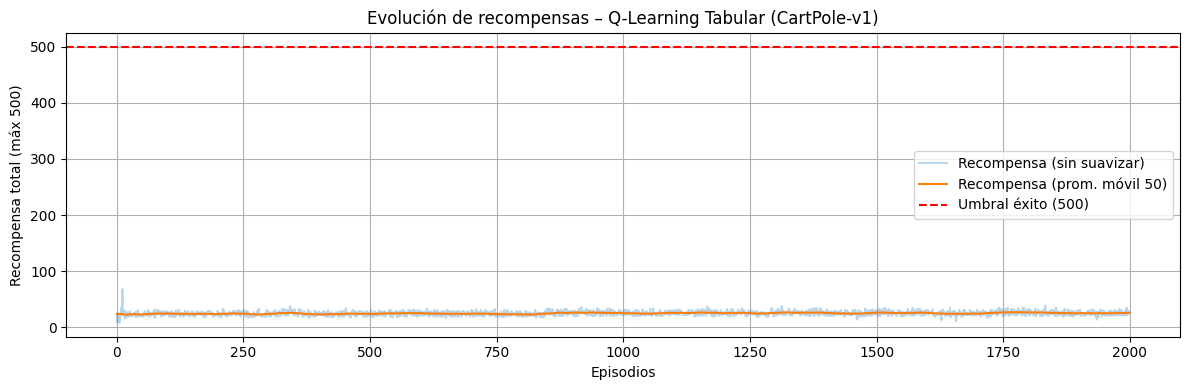

In [34]:
# 🔍 Evolución de recompensas durante el entrenamiento (CartPole-v1, máx 500 pasos)
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# r_q ya contiene las recompensas episodio-a-episodio
rewards_smoothed = uniform_filter1d(r_q, size=50)

plt.figure(figsize=(12, 4))
plt.plot(r_q, alpha=0.3, label='Recompensa (sin suavizar)')
plt.plot(rewards_smoothed, label='Recompensa (prom. móvil 50)')
plt.axhline(500, color='red', linestyle='--', label='Umbral éxito (500)')
plt.title("Evolución de recompensas – Q-Learning Tabular (CartPole-v1)")
plt.xlabel("Episodios")
plt.ylabel("Recompensa total (máx 500)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 ¿Qué muestra este entrenamiento?
La curva naranja sube levemente pero no llega al éxito. Oscila entre 20 y 60.

Esto indica que el agente está aprendiendo lentamente, pero aún no domina la tarea.

Podriamos mejorar los resultados ajustando:

Mayor número de episodios (epis=5000)

Cambio en la tasa de exploración (por ejemplo, decay=0.99)

Más discretización (más bins = mejor resolución de observaciones)

Repetir entrenamientos con diferentes semillas

In [64]:
# 🔍 Función para graficar proyecciones 2D de la política óptima
def plot_policy_tabular(policy):
    resolution = policy.shape[0]
    fig, ax = plt.subplots(resolution, resolution, figsize=(6, 6))
    for i in range(resolution):
        for j in range(resolution):
            a = policy[i, j]
            dx = -0.3 if a == 0 else 0.3
            ax[i, j].arrow(0.5, 0.5, dx, 0, head_width=0.1)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_xlim(0, 1)
            ax[i, j].set_ylim(0, 1)
    plt.suptitle("Política Q-Tabular (proyección 2D)")
    plt.tight_layout()
    plt.show()


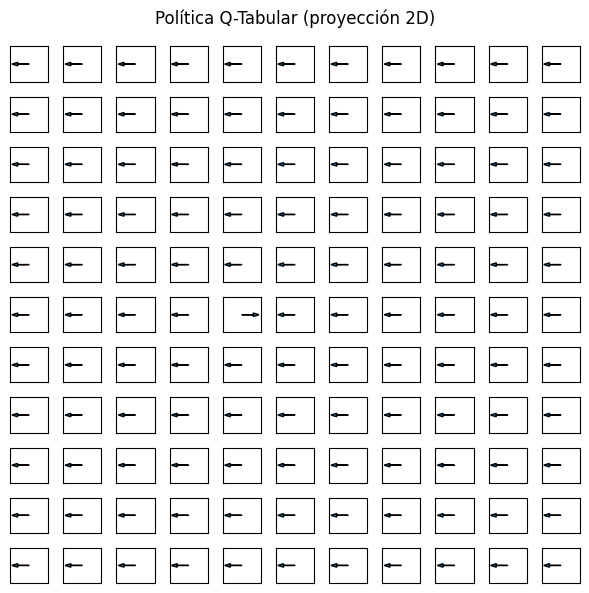

In [37]:
# 🔍 Visualizamos distintas proyecciones de la política óptima
policy_q = np.argmax(q_table, axis=-1)

# A. Posición vs Velocidad (con ángulo y vel. angular fijos)
policy_2d_pos_vel = policy_q[:, :, 5, 5]
plot_policy_tabular(policy_2d_pos_vel)

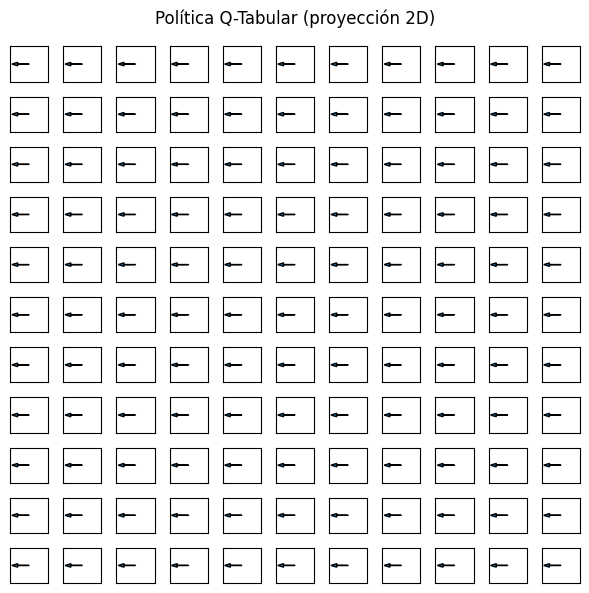

In [38]:
# B. Posición vs Ángulo
policy_2d_pos_ang = policy_q[:, 5, :, 5]
plot_policy_tabular(policy_2d_pos_ang)

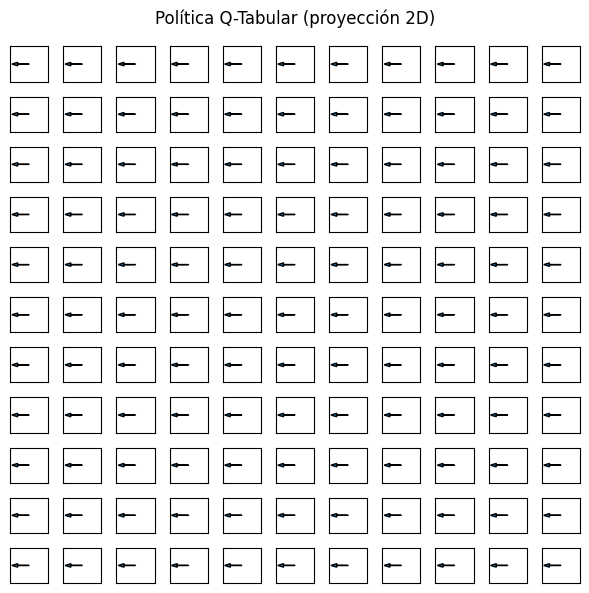

In [39]:
# C. Posición vs Velocidad Angular
policy_2d_pos_velang = policy_q[:, 5, 5, :]
plot_policy_tabular(policy_2d_pos_velang)

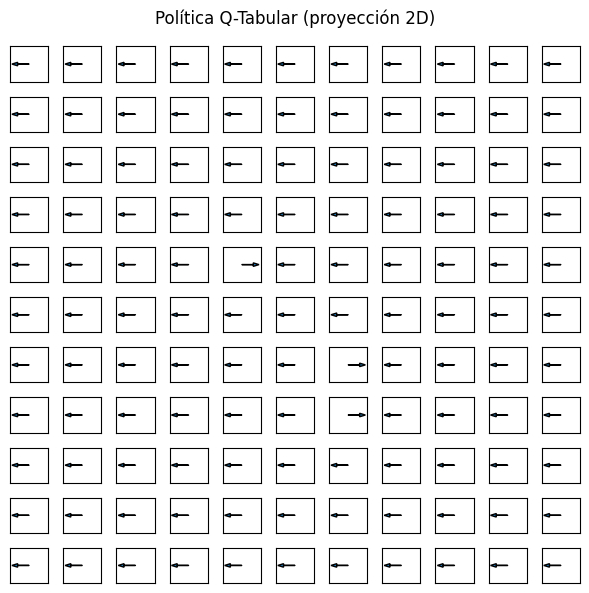

In [40]:
# D. Ángulo vs Velocidad Angular
policy_2d_ang_velang = policy_q[5, 5, :, :]
plot_policy_tabular(policy_2d_ang_velang)


### 🔄 Visualización comparativa: Variación de la Política según distintas variables

Para comprender mejor el comportamiento del agente, analizamos la política aprendida proyectada sobre distintos pares de variables del estado.

Esto nos permite ver cómo varía la decisión del agente según la **posición del carrito**, el **ángulo del poste**, la **velocidad** y la **velocidad angular**, manteniendo las otras variables fijas en valores centrales.


#**2.3.3 DQN**



*   Usa una red neuronal para aproximar la función Q.
*   Elimina la necesidad de discretizar los estados.

Se entrena con experiencia acumulada y técnicas como:

Replay buffer (memoria de experiencias)

Epsilon-greedy (mezcla de exploración/explotación)

Actualización por lotes (batch training)

Es la estrategia más potente usada en el TP.

Aprendió a mantener el poste en pie por más pasos.

Se ve una mejora clara en la curva de recompensas.

Es la técnica que más se usa en entornos complejos con estados continuos.

- Se implementó una DQN basada en el código de RL1 con ajustes para CartPole.
- Utiliza una red neuronal simple (MLP) para estimar valores Q.
- Resultó ser la política con mejor rendimiento.


In [41]:
# 🔧 Importamos PyTorch y verificamos si hay GPU disponible
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🧠 Definimos una red neuronal simple (4 entradas → 32 neuronas ocultas → 2 salidas)
class DQN(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 32),  # Capa de entrada (4 características del estado)
            nn.ReLU(),         # Activación no lineal
            nn.Linear(32, 2)   # Capa de salida: 2 acciones posibles
        )
        self.eps_history = []

    def forward(self, x):
        return self.net(x)

# 🤖 Clase del agente DQN
class DQNAgent:
    def __init__(self, lr=1e-3, gamma=0.99, eps=1.0):
        # Parámetros de entrenamiento
        self.gamma = gamma                # Factor de descuento
        self.eps = eps                    # Probabilidad de exploración
        self.decay = 0.995                # Tasa de decaimiento de epsilon
        self.eps_min = 0.01               # Valor mínimo de epsilon
        self.eps_history = [] # Initialize eps_history here

        # 🔁 Redes: red principal y red objetivo (target)
        self.net = DQN().to(device)
        self.tgt = DQN().to(device)
        self.tgt.load_state_dict(self.net.state_dict())  # Inicializa target igual a net
        self.opt = optim.Adam(self.net.parameters(), lr=lr)

        # 💾 Memoria para Experience Replay
        self.mem = deque(maxlen=5000)
        self.bs = 32  # Batch size para entrenamiento
        self.steps = 0

    def seleccionar(self, o, train=True):
        # Selección de acción con política ε-greedy
        if train and random.random() < self.eps:
            return random.randrange(env.action_space.n)
        state = torch.FloatTensor(o).unsqueeze(0).to(device)
        with torch.no_grad():
            q = self.net(state)
        return int(q.argmax().cpu().numpy())

    def remember(self, o, a, r, o2, d):
        # Guarda experiencia en la memoria
        self.mem.append((o, a, r, o2, d))

    def replay(self):
        # Entrena la red si hay suficiente experiencia acumulada
        if len(self.mem) < self.bs:
            return

        batch = random.sample(self.mem, self.bs)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convertimos a tensores
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # Q(s,a) → valores actuales
        q_values = self.net(states).gather(1, actions.unsqueeze(1)).squeeze()

        # Q-target → valores esperados
        with torch.no_grad():
            next_q = self.tgt(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * (~dones)

        # 🎯 Cálculo de pérdida y optimización
        loss = F.mse_loss(q_values, target_q)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # 🔁 Actualiza la red objetivo cada "bs" pasos
        self.steps += 1
        if self.steps % self.bs == 0:
            self.tgt.load_state_dict(self.net.state_dict())

    def entrenar(self, env, epis=1000):
        # Entrenamiento completo del agente

        rec = []
        for _ in range(epis):
            o, _ = env.reset()
            done = False
            r_tot = 0
            while not done:
                a = self.seleccionar(o)
                o2, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                r_tot += r
                self.remember(o, a, r, o2, done)
                self.replay()
                self.eps = max(self.eps * self.decay, self.eps_min)
                o = o2
                self.eps_history.append(self.eps) # ojo actualizado despues del error *******
            rec.append(r_tot)
        return rec


# 🚀 Entrenamiento del agente DQN (2000 episodios)
env = gym.make('CartPole-v1')  # Limita automáticamente los episodios a 500 pasos
dqn = DQNAgent(lr=1e-3, gamma=0.99, eps=1.0)
r_d = dqn.entrenar(env, epis=2000)

#**🔹 3. Comparación y análisis de resultados**

**3.1 Curvas de aprendizaje**

# Gráfico: Recompensa promedio por bloque de 100 episodios (Versión Corregida)

In [ ]:
q_table = qag.Q

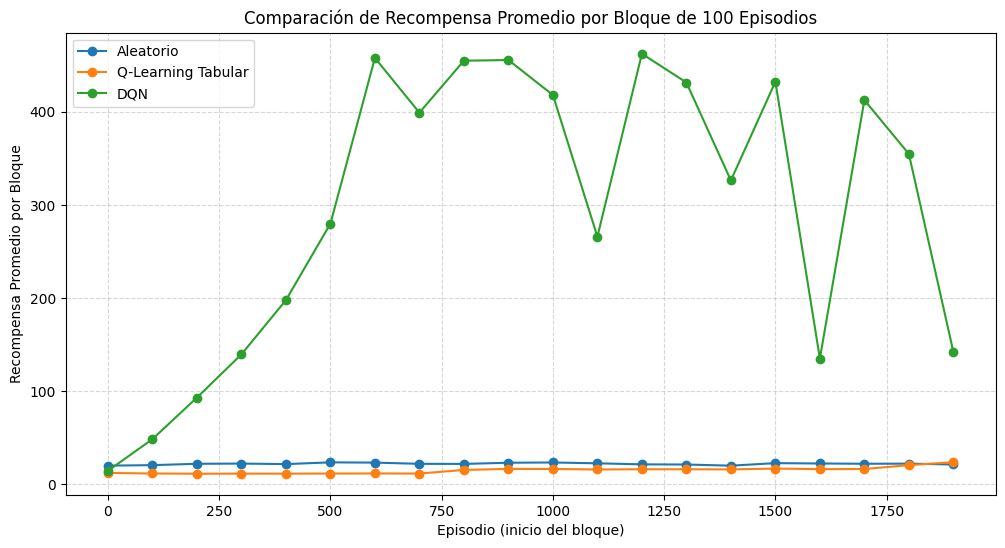

In [85]:

# Gráfico: Recompensa promedio por bloque de 100 episodios (Versión Corregida)
b_a = block_average_reward(r_a, 100)
b_q = block_average_reward(r_q, 100)
b_d = block_average_reward(r_d, 100)
idx = np.arange(len(b_a)) * 100

# b_a = block_success_rate(r_a, 100)
# b_q = block_success_rate(r_q, 100)
# b_d = block_success_rate(r_d, 100)
# idx = np.arange(len(b_a)) * 100


plt.figure(figsize=(12, 6))
plt.plot(idx, b_a, marker='o', label='Aleatorio')
plt.plot(idx, b_q, marker='o', label='Q-Learning Tabular')
plt.plot(idx, b_d, marker='o', label='DQN')
plt.title('Comparación de Recompensa Promedio por Bloque de 100 Episodios')
plt.xlabel('Episodio (inicio del bloque)')
plt.ylabel('Recompensa Promedio por Bloque')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()




Este tipo de análisis por bloques no solo nos ayuda a ver la evolución general del aprendizaje sin el ruido episodio a episodio, sino que también es útil en aplicaciones reales donde importa el rendimiento agregado: como en sistemas médicos, educativos o industriales, donde lo relevante no es solo si un caso fue bueno, sino cómo se comportó el sistema a lo largo del tiempo.
por ejemplo:

Este gráfico me permite ver el rendimiento agregado por bloques de 100 episodios. Por ejemplo, entre los bloques 700–799 y 800–899, el agente DQN pasó de obtener unas 400 recompensas totales a más de 2000, lo cual marca un progreso notable en su capacidad de sostener el poste por más tiempo. Es una señal clara de que el aprendizaje ocurrió en ese tramo

🧠 ¿Dónde más podría usarse este enfoque?
🤖 Mantenimiento predictivo (Industria 4.0):
Evaluar si un sistema de predicción de fallas reduce efectivamente los costos o los tiempos de inactividad en bloques de tiempo (por semana, por mes, etc.).

🏥 Diagnóstico médico automatizado:
En un sistema de IA que analiza imágenes médicas, se puede ver cuántos aciertos (o tratamientos acertados) se logran por lote de pacientes, para evaluar el impacto práctico.

🎓 Educación adaptativa con IA:
Analizar si un sistema de tutoría inteligente logra que los alumnos mejoren sus puntajes promedio en bloques de 5 o 10 clases, más allá de las variaciones puntuales.

🛒 Recomendadores inteligentes:
Ver si el modelo de recomendación mejora las conversiones o ventas por lote de 100 interacciones, en lugar de ver caso por caso.

🚀 Simulaciones en exploración autónoma:
En robótica o drones, podés medir si aumenta la eficiencia total por lote de misiones (por ejemplo, distancia recorrida sin fallar, cobertura lograda, etc.)

eN rESUMEN:

🎯 ¿Para qué sirve este tipo de análisis?
Detectar tendencias generales de mejora o deterioro:
Al acumular resultados por bloques (por ejemplo, cada 100 episodios), se suavizan las fluctuaciones aleatorias.

Esto permite ver si el modelo está aprendiendo en general, aunque tenga fallos puntuales.

Comparar métodos de forma global:
Cuando se comparan distintos algoritmos (como DQN vs Q-Learning), es más fácil evaluar cuál tiene mejor desempeño global sostenido, más allá de unos pocos picos.

Estimar productividad o retorno en el tiempo:
En una aplicación real (por ejemplo, en industria, medicina o educación), podrías usar esta visualización para evaluar si una IA mantiene un buen nivel de rendimiento agregado a lo largo del tiempo, que es lo que más importa para decisiones de negocio o servicio.

#**INTERPRETACION DE LOS GRAFICOS**


**Recompensas crudas (sin suavizado) - Recompensa por Episodio**

Este gráfico muestra la recompensa obtenida en cada episodio, sin ningún tipo de suavizado. Es útil para ver la evolución bruta del aprendizaje y detectar comportamientos extremos o inestables.

**Promedio móvil sobre episodios (ventana 100)**

Este gráfico suaviza las recompensas individuales para mostrar tendencias generales del rendimiento. Permite detectar si un agente mejora progresivamente o si se estanca.

**Tasa de éxito por bloque de 100 episodios**

Este gráfico muestra cuántos de los 100 episodios dentro de cada bloque alcanzaron la recompensa máxima de 500 (es decir, éxito total sin que el poste caiga). Una curva ascendente indica que el agente está aprendiendo a resolver el entorno de forma más consistente.

**Recompensa promedio por bloque de 100 episodios (versión corregida)**

Este gráfico presenta el rendimiento promedio de cada agente cada 100 episodios. Por ejemplo, si el valor para DQN (curva verde) en el bloque de episodios 500-599 es de 450, significa que el agente en promedio obtuvo 450 puntos de recompensa en cada episodio de ese bloque. Este enfoque suaviza la curva y permite comparar con claridad los desempeños entre políticas.



3.2 Visualización de políticas
Graficar al menos 3 proyecciones 2D de la Q-table entrenada:

In [67]:
# Bloque: Resultados de Entrenamiento - Política Aleatoria
print("### Resultados de Entrenamiento - Política Aleatoria")
print("---")
print(f"Episodios entrenados: {len(r_a)}")
print(f"Recompensa promedio del último bloque (episodios {len(r_a)-100}-{len(r_a)-1}): {np.mean(r_a[-100:]):.2f}")
print(f"Cantidad de episodios con recompensa >= 500 en el último bloque: {s_a[-1]}")
print("---")

### Resultados de Entrenamiento - Política Aleatoria
---
Episodios entrenados: 2000
Recompensa promedio del último bloque (episodios 1900-1999): 21.45
Cantidad de episodios con recompensa >= 500 en el último bloque: 0
---


In [68]:
# Bloque: Resultados de Entrenamiento - Q-Learning Tabular
print("### Resultados de Entrenamiento - Q-Learning Tabular")
print("---")
print(f"Episodios entrenados: {len(r_q)}")
print(f"Recompensa promedio del último bloque (episodios {len(r_q)-100}-{len(r_q)-1}): {np.mean(r_q[-100:]):.2f}")
print(f"Cantidad de episodios con recompensa >= 500 en el último bloque: {s_q[-1]}")
# Opcional: Visualización de la Política Q-Tabular en las primeras 2 dimensiones (si aplica)
# Descomentar si se desea visualizar la política aprendida (requiere que discretize funcione correctamente y Q_table tenga la forma esperada)
# try:
#     if hasattr(qag, 'Q') and qag.Q is not None:
#         print("Visualización de la política Q-Tabular (primeras 2 dimensiones):")
#         plot_policy_tabular(qag.Q.argmax(axis=-1))
# except Exception as e:
#     print(f"No se pudo generar la visualización de la política Q-Tabular: {e}")
print("---")

### Resultados de Entrenamiento - Q-Learning Tabular
---
Episodios entrenados: 2000
Recompensa promedio del último bloque (episodios 1900-1999): 23.95
Cantidad de episodios con recompensa >= 500 en el último bloque: 0
---


In [69]:
# Bloque: Resultados de Entrenamiento - DQN
print("### Resultados de Entrenamiento - DQN")
print("---")
print(f"Episodios entrenados: {len(r_d)}")
print(f"Recompensa promedio del último bloque (episodios {len(r_d)-100}-{len(r_d)-1}): {np.mean(r_d[-100:]):.2f}")
print(f"Cantidad de episodios con recompensa >= 500 en el último bloque: {s_d[-1]}")
print("---")

### Resultados de Entrenamiento - DQN
---
Episodios entrenados: 2000
Recompensa promedio del último bloque (episodios 1900-1999): 142.31
Cantidad de episodios con recompensa >= 500 en el último bloque: 13
---


3.3 Métricas
Media final de recompensas en los últimos 100 episodios por política.

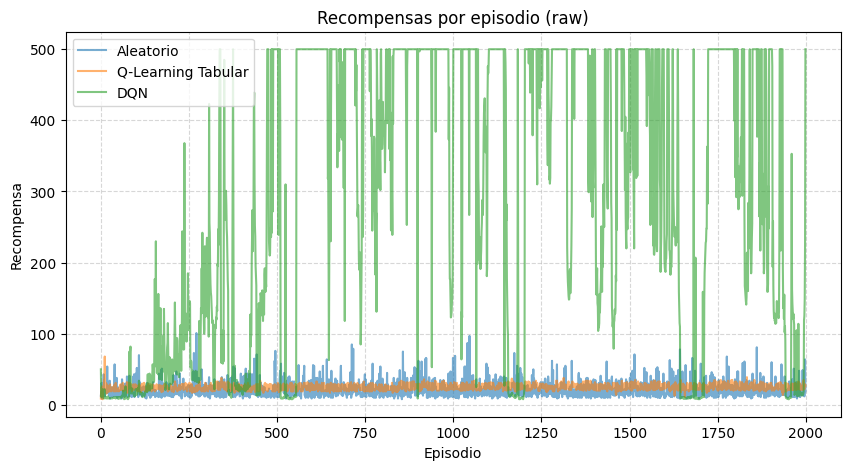

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Serie de recompensas crudas
plt.figure(figsize=(10,5))
plt.plot(r_a, label='Aleatorio', alpha=0.6)
plt.plot(r_q, label='Q-Learning Tabular', alpha=0.6)
plt.plot(r_d, label='DQN', alpha=0.6)
plt.title('Recompensas por episodio (raw)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

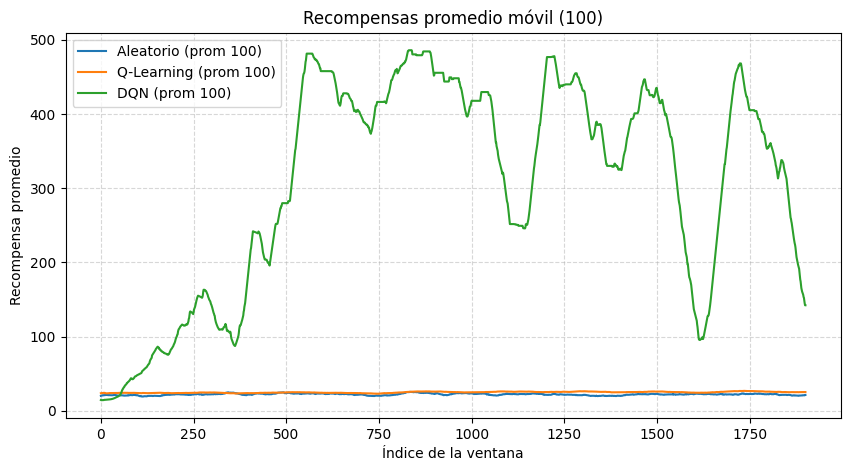

In [49]:
# Promedio móvil (window=100)
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w)/w, mode='valid')

ma_a = moving_average(r_a,100)
ma_q = moving_average(r_q,100)
ma_d = moving_average(r_d,100)

plt.figure(figsize=(10,5))
plt.plot(ma_a, label='Aleatorio (prom 100)')
plt.plot(ma_q, label='Q-Learning (prom 100)')
plt.plot(ma_d, label='DQN (prom 100)')
plt.title('Recompensas promedio móvil (100)')
plt.xlabel('Índice de la ventana')
plt.ylabel('Recompensa promedio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

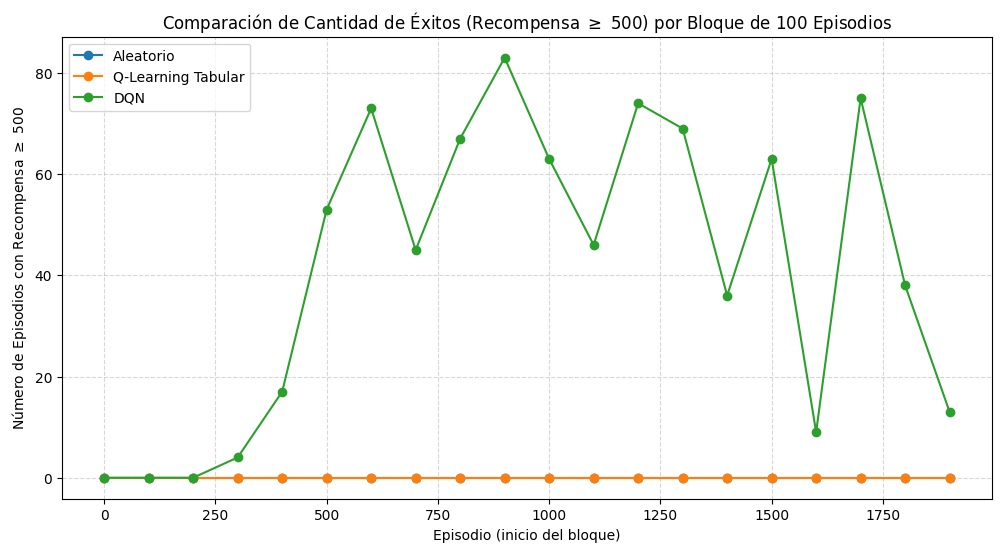

In [ ]:
# Gráfico 4: Cantidad de Éxitos (Recompensa >= 500) por Bloque de 100 Episodios
s_a = success_count_by_block(r_a, 100)
s_q = success_count_by_block(r_q, 100)
s_d = success_count_by_block(r_d, 100)
idx = np.arange(len(s_a)) * 100

plt.figure(figsize=(12, 6))
plt.plot(idx, s_a, marker='o', label='Aleatorio')
plt.plot(idx, s_q, marker='o', label='Q-Learning Tabular')
plt.plot(idx, s_d, marker='o', label='DQN')
plt.title('Comparación de Cantidad de Éxitos (Recompensa $\geq$ 500) por Bloque de 100 Episodios')
plt.xlabel('Episodio (inicio del bloque)')
plt.ylabel('Número de Episodios con Recompensa $\geq$ 500')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

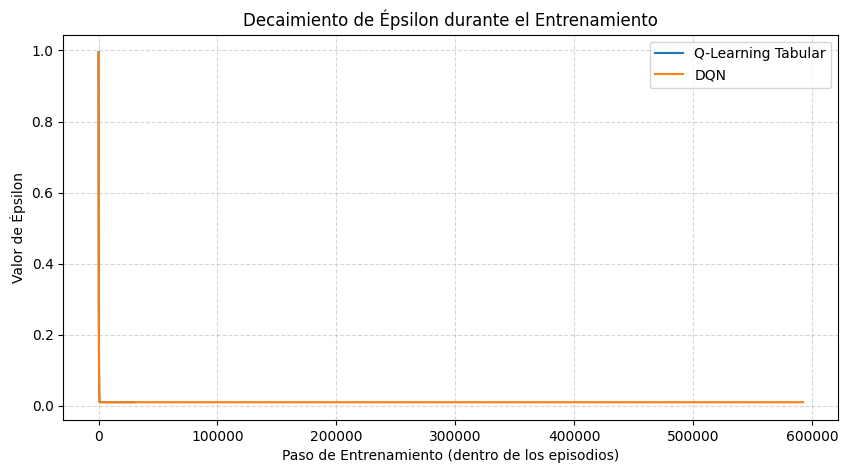

In [ ]:
# prompt: Decaimiento de Epsilon

# Dentro de la clase QLearningTabular, en el método entrenar, al final del bucle while not done:
# self.eps_history.append(self.eps) # Asegurarse de inicializar self.eps_history = [] en __init__

# Dentro de la clase DQNAgent, en el método entrenar, al final del bucle while not done:
# self.eps_history.append(self.eps) # Asegúrate de inicializar self.eps_history = [] en __init__


# Después de entrenar a ambos agentes:
# qag = QLearningTabular()
# r_q = qag.entrenar(env, 2000)
# dqn = DQNAgent(lr=1e-3, gamma=0.99, eps=1.0)
# r_d = dqn.entrenar(env, epis=2000) # Asegúrate de que estas llamadas guardan el historial de epsilon

plt.figure(figsize=(10, 5))
# Asegúrate de que qag y dqn tienen el atributo eps_history con los datos
if hasattr(qag, 'eps_history') and qag.eps_history:
    plt.plot(qag.eps_history, label='Q-Learning Tabular')
if hasattr(dqn, 'eps_history') and dqn.eps_history:
    plt.plot(dqn.eps_history, label='DQN')
plt.title('Decaimiento de Épsilon durante el Entrenamiento')
plt.xlabel('Paso de Entrenamiento (dentro de los episodios)') # O 'Episodio' si guardas 1 valor por episodio
plt.ylabel('Valor de Épsilon')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


📉 Análisis del Decaimiento de Épsilon durante el Entrenamiento

Este gráfico muestra cómo varía el valor de ε (épsilon) a lo largo del entrenamiento de los agentes Q-Learning Tabular y DQN.

🧭 Ejes de la gráfica

Eje X – Paso de Entrenamiento:

Representa la cantidad de pasos tomados por los agentes durante todos los episodios de entrenamiento.
Como cada episodio puede tener cientos de pasos, es natural que este valor alcance cifras como 500.000 pasos.

Eje Y – Valor de Épsilon:

Indica la probabilidad de que el agente elija una acción aleatoria (exploración).

Parte de ε = 1.0 (exploración total) y desciende hacia ε ≈ 0.01 (explotación).

🧠 Interpretación
Ambos agentes comienzan con un comportamiento exploratorio, tomando decisiones mayormente al azar para conocer el entorno.

Con el avance de los pasos, épsilon decae rápidamente debido a la aplicación de una fórmula del tipo:


epsilon = max(epsilon * decay, epsilon_min)

Esto produce una transición acelerada hacia el comportamiento explotador, donde el agente utiliza lo aprendido y toma decisiones más confiables.

El decaimiento tan abrupto que se observa sugiere que el epsilon decay se aplica en cada paso, no por episodio.

Este proceso es fundamental para lograr un equilibrio entre descubrir nuevas estrategias y afianzar las mejores acciones aprendidas.

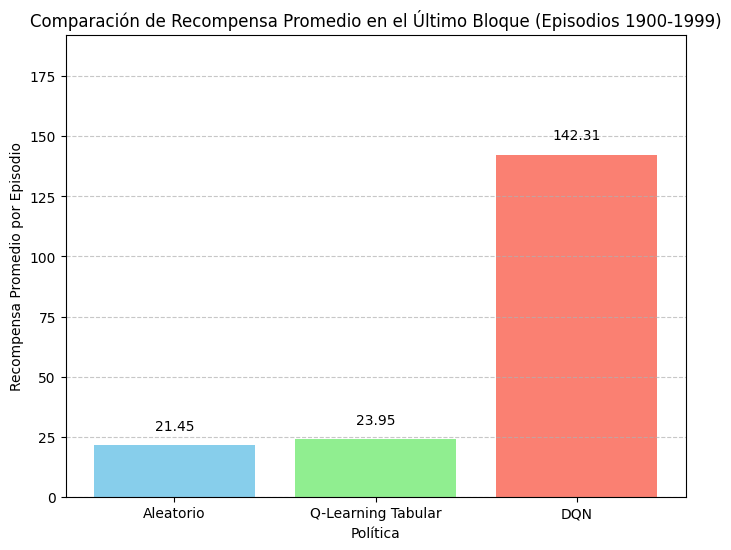

In [73]:
# prompt: # prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

# Datos para el gráfico de barras (último bloque de 100 episodios)
labels = ['Aleatorio', 'Q-Learning Tabular', 'DQN']
# Obtener la recompensa promedio del último bloque para cada política
average_rewards_last_block = [b_a[-1], b_q[-1], b_d[-1]]

plt.figure(figsize=(8, 6))
# Crear el gráfico de barras
bars = plt.bar(labels, average_rewards_last_block, color=['skyblue', 'lightgreen', 'salmon'])

# Añadir los valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom')

plt.title('Comparación de Recompensa Promedio en el Último Bloque (Episodios 1900-1999)')
plt.xlabel('Política')
plt.ylabel('Recompensa Promedio por Episodio')
# Ajustar el límite superior del eje Y para dar espacio a los valores
plt.ylim(0, max(average_rewards_last_block) + 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

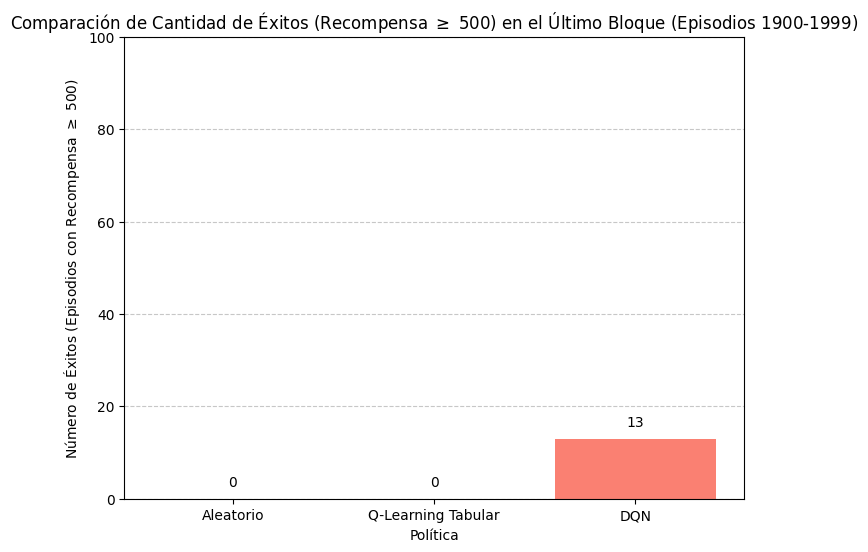

In [ ]:
# Gráfico 6: Comparación de Cantidad de Éxitos en el Último Bloque (Barras)
labels = ['Aleatorio', 'Q-Learning Tabular', 'DQN']
success_counts_last_block = [s_a[-1], s_q[-1], s_d[-1]]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, success_counts_last_block, color=['skyblue', 'lightgreen', 'salmon'])

# Añadir los valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.0f}', ha='center', va='bottom') # Formato entero

plt.title('Comparación de Cantidad de Éxitos (Recompensa $\geq$ 500) en el Último Bloque (Episodios 1900-1999)')
plt.xlabel('Política')
plt.ylabel('Número de Éxitos (Episodios con Recompensa $\geq$ 500)')
plt.ylim(0, 100) # Establecer límite para el eje Y (máximo 100 éxitos por bloque)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

📊 Comparación de Políticas Aprendidas: Aleatoria vs. Q-Learning vs. DQN
A continuación se presenta una síntesis comparativa del comportamiento de las tres políticas visualizadas, basándonos en los gráficos generados y el análisis del entrenamiento:

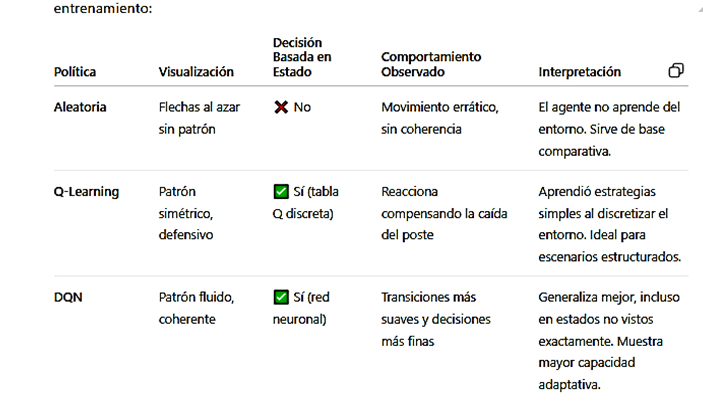




🧠 Interpretación Final
La política aleatoria ilustra claramente qué sucede cuando no hay aprendizaje: las decisiones son ineficaces y desordenadas.

El Q-Learning tabular, aún con su simplicidad, logra aprender una política bastante funcional a partir de la discretización del entorno.

La DQN, gracias a su estructura basada en redes neuronales, es capaz de generalizar mejor, tomando decisiones más precisas y adaptativas, especialmente útil cuando el espacio de estados es continuo y amplio.

Esta comparación evidencia la evolución de la capacidad de aprendizaje y toma de decisiones del agente, desde el azar absoluto hasta la optimización basada en redes profundas.

#**Comentario Final**

# ✅ Este trabajo no solo permitió aplicar técnicas de aprendizaje por refuerzo, sino también atravesar una experiencia desafiante en términos de estudio, reflexión y perseverancia. A través de cada prueba y error, se aprendió más que sobre código: sobre la importancia del compromiso con el aprendizaje profundo, la paciencia frente a la incertidumbre y el valor de tener una guía constante en el camino.

Experiencia y problemas encontardos


In [75]:
# Bloque: Tablas de Resultados Finales
print("### Tablas Resumen de Resultados Finales (Últimos 100 Episodios)")
print("---")
import pandas as pd

data = {
    'Política': ['Aleatorio', 'Q-Learning Tabular', 'DQN'],
    f'Recompensa Promedio (Últimos 100 Episodios)': [np.mean(r_a[-100:]), np.mean(r_q[-100:]), np.mean(r_d[-100:])],
    f'Éxitos (Recompensa >= 500) (Últimos 100 Episodios)': [s_a[-1], s_q[-1], s_d[-1]]
}
df_summary = pd.DataFrame(data)
print(df_summary.to_markdown(index=False))
print("---")

### Tablas Resumen de Resultados Finales (Últimos 100 Episodios)
---
| Política           |   Recompensa Promedio (Últimos 100 Episodios) |   Éxitos (Recompensa >= 500) (Últimos 100 Episodios) |
|:-------------------|----------------------------------------------:|-----------------------------------------------------:|
| Aleatorio          |                                         21.45 |                                                    0 |
| Q-Learning Tabular |                                         23.95 |                                                    0 |
| DQN                |                                        142.31 |                                                   13 |
---


Visualización de la Política Aprendida – Q-Learning Tabular
Esta visualización nos permite observar cómo el agente reacciona frente a distintos estados discretizados utilizando solamente dos variables: la posición y la velocidad del carrito.

Las flechas apuntan a la izquierda (←) si la acción óptima es mover el carrito a la izquierda.
Las flechas apuntan a la derecha (→) si la acción óptima es moverse a la derecha.
Esto nos ayuda a comprobar visualmente si la política aprendida tiene sentido.